In [1]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## 1. Зависимости среднего значения разности фаз и ее стандартного отклонения на всем промежутке времени для разных значений затухания и фиксированного значения времени переключения. 
### Ожидание: показать как влияе затухание на "определенность" тока

 

In [2]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.01*np.pi # шаг генерации
beta = 0.0276 # температурный делитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
phix = 0 # 

In [3]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

In [4]:
def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

In [5]:
alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi)


In [6]:
# параметры
# gamma = 0.01 # коэффициент затухания
tau = 1000 # характерное время переключения
T = 1010 # полный интервал времени
dt = 0.1 # шаг по времени
t = np.linspace(0,T, int(T/dt))


In [7]:
def phixx(t): # функция именения параметра управления
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1) 
    
def H(t, phi, p):
    return p**2/2 + (phi-phixx(t))**2/(2*lq) + 1 - np.cos(phi)

def F(t, phi, p):
    return p, -np.sin(phi) - (phi - phix - np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1))/lq - gamma*p

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [05:04<00:00, 33.20it/s]


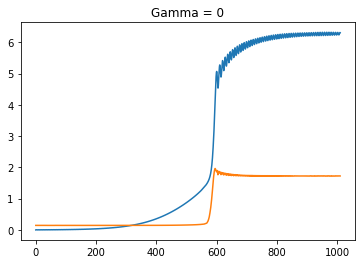

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [05:13<00:00, 32.20it/s]


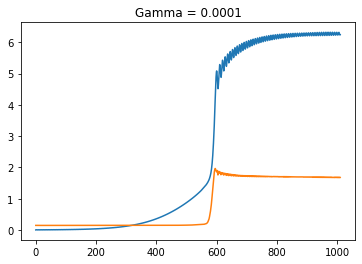

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [04:48<00:00, 35.01it/s]


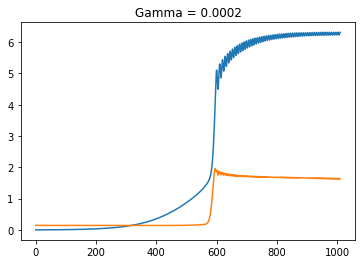

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [05:51<00:00, 28.74it/s]


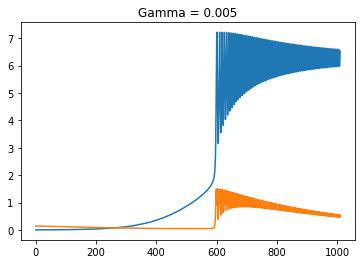

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [04:55<00:00, 34.23it/s]


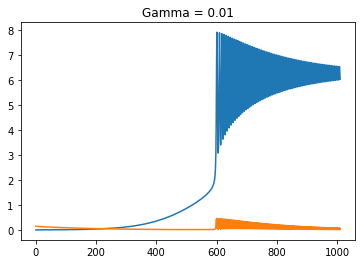

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [04:34<00:00, 36.81it/s]


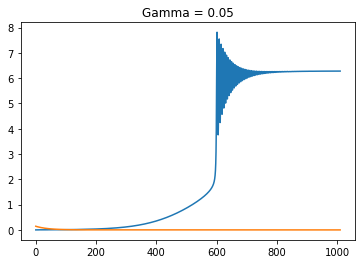

 67%|███████████████████████████████████████████████████▎                         | 6726/10100 [03:03<01:30, 37.33it/s]

KeyboardInterrupt: 

In [8]:
# Выход: mean(t), std(t)
g = [0, 0.0001, 0.0002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

for gamma in g:
    mean = []
    std = []
    # начальное распределение
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(beta), Num)
    # главный цикл
    for it in tqdm(t):
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
        mean.append(np.mean(phi_points))
        std.append(np.std(phi_points))

    plt.plot(t, mean, label = 'mean_phi')
    plt.plot(t, std, label = 'std')
    plt.title('Gamma = {}'.format(gamma))
    plt.show()

## 2. Зависимость среднего значения разности фаз и его дисперсии (разброса) в после переключения (tau + 10). 
### Ожидание: получить адиабатическое время перекллючения. Ожидается, что после некоторого tau для случая без затухания дисперсия менятся уже не будет.

In [36]:
tau_points = np.linspace(100, 4000, 40)
mean_tau = []
std_tau = []
gamma = 0
for tau in tau_points:
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(beta), Num)
    T = tau + 10
    t = np.linspace(0, T, int(T/dt))
    # главный цикл
    for it in tqdm(t):
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    mean_tau.append(np.mean(phi_points))
    std_tau.append(np.std(phi_points))
    



100%|███████████████████████████████████████████████████████████████████████████| 40100/40100 [05:19<00:00, 125.61it/s]


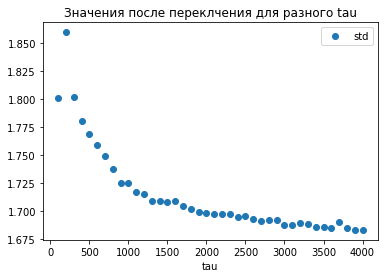

In [48]:
#plt.plot(tau_points, mean_tau, label = 'mean')
plt.plot(tau_points, std_tau, 'o', label = 'std')
plt.legend()
plt.xlabel('tau')
plt.title("Значения после переклчения для разного tau")
plt.show()

### Можно ли точку перегиба использовать для анализа бездиссипативного адиабатического переключения?

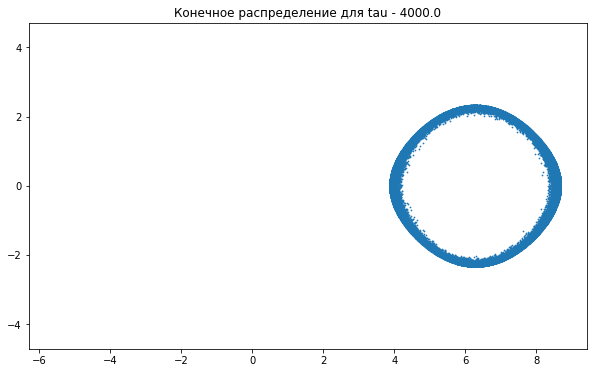

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
plt.xlim(-2*np.pi+phix, 3*np.pi+phix)
plt.ylim(-1.5*np.pi, 1.5*np.pi)
plt.title('Конечное распределение для tau - {}'.format(tau))
plt.show()

In [44]:
tau = 1000
np.random.seed(1997)
random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points_1 = inter_func(random_points) # значения phi c требуемым распределением
p_points_1 = np.random.normal(0, np.sqrt(beta), Num)
T = tau + 10
t = np.linspace(0, T, int(T/dt))
# главный цикл
for it in tqdm(t):
    k1 = F(it, phi_points_1, p_points_1)
    k2 = F(it+dt/2, phi_points_1 + dt*k1[0]/2, p_points_1 + dt*k1[1]/2)
    k3 = F(it+dt/2, phi_points_1 + dt*k2[0]/2, p_points_1 + dt*k2[1]/2)
    k4 = F(it+dt, phi_points_1 + dt*k3[0], p_points_1 + dt*k3[1])
    phi_points_1 = phi_points_1 + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
    p_points_1 = p_points_1 + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [01:41<00:00, 99.97it/s]


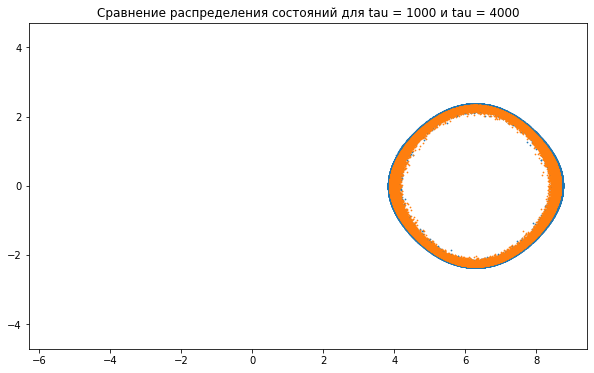

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(phi_points_1, p_points_1, s = 0.5) # s - размер точек
plt.scatter(phi_points, p_points, s = 0.5) 
plt.xlim(-2*np.pi+phix, 3*np.pi+phix)
plt.ylim(-1.5*np.pi, 1.5*np.pi)
plt.title('Сравнение распределения состояний для tau = 1000 и tau = 4000')
plt.show()